In [23]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

import itertools
from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime
from scipy import optimize
import re
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import logomaker

In [2]:
def simplify_motif_name(name):
    """
    """
#     new_name = name.split('/')[0]
    new_name = name.split('(')[0]
    return new_name

def simplify_enhclst_name(name):
    """
    """
    if name.startswith('clst'):
        name = name[4:]
    new_name = name.split('_')[0]
    return new_name

def p2f(text):
    """Convert percentage to float 
    """
    return np.float(text.strip('%'))/100

In [3]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# pmf(k, M, n, N) = choose(n, k) * choose(M - n, N - k) / choose(M, N),
#                                for max(0, N - (M-n)) <= k <= min(n, N)
# k/x - sample positives 
# M - all
# N - samples
# n - all positives
# # stats.hypergeom.sf(x, M, n, N) # 1-cdf

# k - fg positives; mat_fg
# M - all regions; mat_fg + mat_nfg + mat_bg + mat_nbg
# N - fg regions; mat_fg + mat_nfg
# n - all positives; mat_fg + mat_bg 

def hypogeom_test_pipe(k, M, n, N, mode='enrichment'):
    """multiple correction on each col
    """
    # enrichment pvalue (one-sided); 20s
    if mode == 'enrichment':
        pvals = stats.hypergeom.sf(k, M, n, N)
    elif mode == 'depletion':
        pvals = stats.hypergeom.cdf(k, M, n, N)
    elif mode == 'both':
        cdfs = stats.hypergeom.cdf(k, M, n, N)
        sfs = stats.hypergeom.sf(k, M, n, N)
        pvals = 2*np.minimum(cdfs, sfs)
    else:
        raise ValueError
        
    pvals = pd.DataFrame(pvals, index=k.index, columns=k.columns)

    # adj pvalues
    adjpvals = pd.DataFrame(index=k.index, columns=k.columns)
    for col in pvals:
        _, adjpval, _, _ = multipletests(pvals[col], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        adjpvals[col] = adjpval
    
    return pvals, adjpvals

# Load data 

In [4]:
MERGE_SIMILAR_MOTIFS = False 
MERGE_SIMILAR_MOTIFS_ADHOC = False 



today = datetime.date.today()
output_figures = "/cndd2/fangming/projects/scf_enhancers/results/{{}}_{}.pdf".format(today)
print(output_figures)
print(today)

/cndd2/fangming/projects/scf_enhancers/results/{}_2020-10-20.pdf
2020-10-20


In [5]:
# 418 vs 234
    
# all motif pwms
f_pattern = "/cndd2/fangming/software/homer/motifs/*.motif"
files = np.sort(glob.glob(f_pattern))

motif_pwms = {}
for file in files:
    df = pd.read_csv(file, sep='\t', skiprows=1, header=None)
    df.columns = ['A', 'C', 'G', 'T']
    
    with open(file, 'r') as fh:
        header = fh.readline()
        name = header.split('\t')[1]
        simp_name = simplify_motif_name(name) 
    
    if simp_name not in motif_pwms.keys():
        motif_pwms[simp_name] = df

all_motifs = np.sort(list(motif_pwms.keys()))

# groupby all motif clusters 
f = '/cndd2/fangming/references/homer_known_motif_clusters.pkl'
with open(f, 'rb') as fh:
    known_motif_clusters = pickle.load(fh)
    print(len(known_motif_clusters))

similar_motif_dict = {}
for motif_clst in known_motif_clusters:
    for motif in motif_clst:
        similar_motif_dict[motif] = motif_clst[0]
# similar_motif_dict = pd.Series(similar_motif_dict)

if MERGE_SIMILAR_MOTIFS:

    # use the first element in each motif cluster as the representative
    all_motifs = [clst[0] for clst in known_motif_clusters]


print(len(all_motifs))    
print(len(similar_motif_dict))
df.head() 

234
418
418


,A,C,G,T
0,0.092,0.351,0.370,0.187
1,0.302,0.419,0.143,0.135
2,0.183,0.395,0.219,0.204
3,0.574,0.032,0.215,0.179
4,0.167,0.032,0.785,0.016


In [6]:
# HOMER all motif enrichment results
# cluster by conditions (all, correlated, linked)

f_pattern = '/cndd2/fangming/projects/scf_enhancers/motifs/20200907/*/knownResults.txt'
files = np.sort(glob.glob(f_pattern))

motif_res = {}
for file in files:
    clst, catg = file.split('/')[-2].split('_')[-2:]
    df = pd.read_csv(file, sep="\t")
    df['Motif Name'] = df['Motif Name'].apply(simplify_motif_name)
    df = df.groupby('Motif Name').first() # remove dup
    df = df.reindex(all_motifs)
    motif_res["{}_{}".format(clst, catg)] = df
    
    df.columns = ['consensus', 'p', 'logp', 'q', 'num_fg', 'frac_fg', 'num_bg', 'frac_bg']
    df['frac_fg'] = df['frac_fg'].apply(p2f)
    df['frac_bg'] = df['frac_bg'].apply(p2f)
    
    print(clst, catg, df.shape)

clst0 all (418, 8)
clst0 correlated (418, 8)
clst0 linked (418, 8)
clst1 all (418, 8)
clst1 correlated (418, 8)
clst1 linked (418, 8)
clst2 all (418, 8)
clst2 correlated (418, 8)
clst2 linked (418, 8)
clst3 all (418, 8)
clst3 correlated (418, 8)
clst3 linked (418, 8)
clst4 all (418, 8)
clst4 correlated (418, 8)
clst4 linked (418, 8)
clst5 all (418, 8)
clst5 correlated (418, 8)
clst5 linked (418, 8)
clst6 all (418, 8)
clst6 correlated (418, 8)
clst6 linked (418, 8)
clst7 all (418, 8)
clst7 correlated (418, 8)
clst7 linked (418, 8)
clst8 all (418, 8)
clst8 correlated (418, 8)
clst8 linked (418, 8)
clst9 all (418, 8)
clst9 correlated (418, 8)
clst9 linked (418, 8)


In [7]:
# HOMER all motif enrichment results
# cluster by conditions (all, correlated, linked)

f_pattern = '/cndd2/fangming/projects/scf_enhancers/motifs/20201005_shuffled/*/knownResults.txt'
files = np.sort(glob.glob(f_pattern))

motif_res_shuff = {}
for file in files:
    clst, catg = file.split('/')[-2].split('_')[-2:]
    catg = catg.split('.')[0] # for shuffled
    df_shuff = pd.read_csv(file, sep="\t")
    df_shuff['Motif Name'] = df_shuff['Motif Name'].apply(simplify_motif_name)
    df_shuff = df_shuff.groupby('Motif Name').first() # remove dup
    df_shuff = df_shuff.reindex(all_motifs)
    motif_res_shuff["{}_{}".format(clst, catg)] = df_shuff
    
    df_shuff.columns = ['consensus', 'p', 'logp', 'q', 'num_fg', 'frac_fg', 'num_bg', 'frac_bg']
    df_shuff['frac_fg'] = df_shuff['frac_fg'].apply(p2f)
    df_shuff['frac_bg'] = df_shuff['frac_bg'].apply(p2f)
    
    print(clst, catg, df_shuff.shape)

clst0 all (418, 8)
clst0 correlated (418, 8)
clst0 linked (418, 8)
clst1 all (418, 8)
clst1 correlated (418, 8)
clst1 linked (418, 8)
clst2 all (418, 8)
clst2 correlated (418, 8)
clst2 linked (418, 8)
clst3 all (418, 8)
clst3 correlated (418, 8)
clst3 linked (418, 8)
clst4 all (418, 8)
clst4 correlated (418, 8)
clst4 linked (418, 8)
clst5 all (418, 8)
clst5 correlated (418, 8)
clst5 linked (418, 8)
clst6 all (418, 8)
clst6 correlated (418, 8)
clst6 linked (418, 8)
clst7 all (418, 8)
clst7 correlated (418, 8)
clst7 linked (418, 8)
clst8 all (418, 8)
clst8 correlated (418, 8)
clst8 linked (418, 8)
clst9 all (418, 8)
clst9 correlated (418, 8)
clst9 linked (418, 8)


In [8]:
df_shuff.head()

,consensus,p,logp,q,num_fg,frac_fg,num_bg,frac_bg
Motif Name,,,,,,,,
AMYB,TGGCAGTTGG,1.0,-0.01063,1.0,35.0,0.2734,18387.2,0.3659
AP-1,VTGACTCATC,1.0,-0.07280,1.0,18.0,0.1406,9368.1,0.1864
AP-2alpha,ATGCCCTGAGGC,1.0,-0.59440,1.0,13.0,0.1016,5135.2,0.1022
AP-2gamma,SCCTSAGGSCAW,1.0,-0.88470,1.0,19.0,0.1484,6971.2,0.1387
AR-halfsite,CCAGGAACAG,1.0,-0.04455,1.0,89.0,0.6953,38064.9,0.7574


In [9]:
df.head()

,consensus,p,logp,q,num_fg,frac_fg,num_bg,frac_bg
Motif Name,,,,,,,,
AMYB,TGGCAGTTGG,1.0,-1.640000,0.9214,57.0,0.4254,18969.2,0.3854
AP-1,VTGACTCATC,0.1,-3.392000,0.7594,33.0,0.2463,8864.2,0.1801
AP-2alpha,ATGCCCTGAGGC,1.0,-0.122400,1.0000,18.0,0.1343,8318.9,0.1690
AP-2gamma,SCCTSAGGSCAW,1.0,-0.291500,1.0000,27.0,0.2015,10928.3,0.2220
AR-halfsite,CCAGGAACAG,1.0,-0.004086,1.0000,96.0,0.7164,39716.8,0.8070


# Proc data

In [10]:
# q-value
mat_qval = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    mat_qval[key] = val['q'] # match axis
print(mat_qval.shape)
    
# log2FC
mat_fc = pd.DataFrame(index=df.index) 
for key, val in motif_res.items():
    mat_fc[key] = np.log2(val['frac_fg']/val['frac_bg']) # match axis
print(mat_fc.shape)
 
# Counts_fg
mat_fg = pd.DataFrame(index=df.index) 
mat_nfg = pd.DataFrame(index=df.index) 
total_fg = {}
for key, val in motif_res.items():
    # match axis (df index)
    total_fg[key] = int((val['num_fg']/val['frac_fg']).median())
    mat_fg[key] = val['num_fg']
    mat_nfg[key] = total_fg[key] - val['num_fg']
    
print(mat_fg.shape)

# Counts_bg
mat_bg = pd.DataFrame(index=df.index) 
mat_nbg = pd.DataFrame(index=df.index) 
total_bg = {}
for key, val in motif_res.items():
    # match axis (df index)
    total_bg[key] = int((val['num_bg']/val['frac_bg']).median())
    mat_bg[key] = val['num_bg']
    mat_nbg[key] = total_bg[key] - val['num_fg']
    
print(mat_bg.shape)

(418, 30)
(418, 30)
(418, 30)
(418, 30)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# q-value
mat_shuff_qval = pd.DataFrame(index=df_shuff.index) 
for key, val in motif_res_shuff.items():
    mat_shuff_qval[key] = val['q'] # mat_shuffch axis
print(mat_shuff_qval.shape)
    
# log2FC
mat_shuff_fc = pd.DataFrame(index=df_shuff.index) 
for key, val in motif_res_shuff.items():
    mat_shuff_fc[key] = np.log2(val['frac_fg']/val['frac_bg']) # mat_shuffch axis
print(mat_shuff_fc.shape)
 
# Counts_fg
mat_shuff_fg = pd.DataFrame(index=df_shuff.index) 
mat_shuff_nfg = pd.DataFrame(index=df_shuff.index) 
total_fg = {}
for key, val in motif_res_shuff.items():
    # mat_shuffch axis (df_shuff index)
    total_fg[key] = int((val['num_fg']/val['frac_fg']).median())
    mat_shuff_fg[key] = val['num_fg']
    mat_shuff_nfg[key] = total_fg[key] - val['num_fg']
    
print(mat_shuff_fg.shape)

# Counts_bg
mat_shuff_bg = pd.DataFrame(index=df_shuff.index) 
mat_shuff_nbg = pd.DataFrame(index=df_shuff.index) 
total_bg = {}
for key, val in motif_res_shuff.items():
    # mat_shuffch axis (df_shuff index)
    total_bg[key] = int((val['num_bg']/val['frac_bg']).median())
    mat_shuff_bg[key] = val['num_bg']
    mat_shuff_nbg[key] = total_bg[key] - val['num_fg']
    
print(mat_shuff_bg.shape)

(418, 30)
(418, 30)
(418, 30)
(418, 30)


In [12]:
k = mat_fg
M = mat_fg+mat_nfg+mat_bg+mat_nbg
N = mat_fg+mat_nfg
n = mat_fg+mat_bg

_, adjpvals_v0 = hypogeom_test_pipe(k, M, n, N, mode='both')
log2fc_v0 = np.log2((k/N)/(n/M))

<ipython-input-12-f036f6aaf06d>:7: RuntimeWarning: divide by zero encountered in log2
  log2fc_v0 = np.log2((k/N)/(n/M))


In [13]:
k = mat_shuff_fg
M = mat_shuff_fg+mat_shuff_nfg+mat_shuff_bg+mat_shuff_nbg
N = mat_shuff_fg+mat_shuff_nfg
n = mat_shuff_fg+mat_shuff_bg

_, adjpvals_shuff_v0 = hypogeom_test_pipe(k, M, n, N, mode='both')
log2fc_shuff_v0 = np.log2((k/N)/(n/M))

<ipython-input-13-b94ca1b13765>:7: RuntimeWarning: divide by zero encountered in log2
  log2fc_shuff_v0 = np.log2((k/N)/(n/M))


# Plot 

In [14]:
to_plot = np.clip(-np.log10(adjpvals_v0), 0, 20)
to_plot2 = log2fc_v0 
print(to_plot.shape)
print(to_plot2.shape)

# # filter motifs
# fdr_th = 10 # 10^-10
# log2fc_th = 0.1
# cond = (((to_plot>fdr_th) & (to_plot2>log2fc_th)).sum(axis=1) > 0) # positive in at least 1 group

# to_plot = to_plot[cond].copy()
# to_plot2 = to_plot2[cond].copy()
# print(to_plot.shape)
# print(to_plot2.shape)

# merge motifs (adhoc)
if MERGE_SIMILAR_MOTIFS_ADHOC:
    to_plot['motif_clst'] = [similar_motif_dict[motif] 
                             for motif in to_plot.index]
    to_plot = to_plot.groupby('motif_clst').max()
    print(to_plot.shape)
    
    to_plot2['motif_clst'] = [similar_motif_dict[motif] 
                             for motif in to_plot2.index]
    to_plot2 = to_plot2.groupby('motif_clst').max()
    print(to_plot2.shape)
    
mat_labels = [
    'all', 'correlated', 'linked',
]

mats = [
    to_plot.filter(regex=r'_all$', axis=1),    
    to_plot.filter(regex=r'_correlated$', axis=1),    
    to_plot.filter(regex=r'_linked$', axis=1),    
]

mats2 = [
    to_plot2.filter(regex=r'_all$', axis=1),    
    to_plot2.filter(regex=r'_correlated$', axis=1),    
    to_plot2.filter(regex=r'_linked$', axis=1),    
]

(418, 30)
(418, 30)


<ipython-input-14-391f81fb4ede>:1: RuntimeWarning: divide by zero encountered in log10
  to_plot = np.clip(-np.log10(adjpvals_v0), 0, 20)


In [15]:
to_plot_shuff = np.clip(-np.log10(adjpvals_shuff_v0), 0, 20)
to_plot_shuff2 = log2fc_shuff_v0 
print(to_plot_shuff.shape)
print(to_plot_shuff2.shape)

# to_plot_shuff = to_plot_shuff[cond.reindex(to_plot_shuff.index)].copy()
# to_plot_shuff2 = to_plot_shuff2[cond].copy()
# print(to_plot_shuff.shape)
# print(to_plot_shuff2.shape)

# merge motifs (adhoc)
if MERGE_SIMILAR_MOTIFS_ADHOC:
    to_plot_shuff['motif_clst'] = [similar_motif_dict[motif] 
                             for motif in to_plot_shuff.index]
    to_plot_shuff = to_plot_shuff.groupby('motif_clst').max()
    print(to_plot_shuff.shape)
    
    to_plot_shuff2['motif_clst'] = [similar_motif_dict[motif] 
                             for motif in to_plot_shuff2.index]
    to_plot_shuff2 = to_plot_shuff2.groupby('motif_clst').max()
    print(to_plot_shuff2.shape)

(418, 30)
(418, 30)


<ipython-input-15-901f13b63b2e>:1: RuntimeWarning: divide by zero encountered in log10
  to_plot_shuff = np.clip(-np.log10(adjpvals_shuff_v0), 0, 20)


In [16]:
# hierarchical clustering (motif and cluster order)
pmat = mats[0] #>fdr_th

Z = sch.linkage(pmat, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
motif_orders = np.array(g['ivl']).astype(int)

Z = sch.linkage(pmat.T, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
clst_orders = np.array(g['ivl']).astype(int)

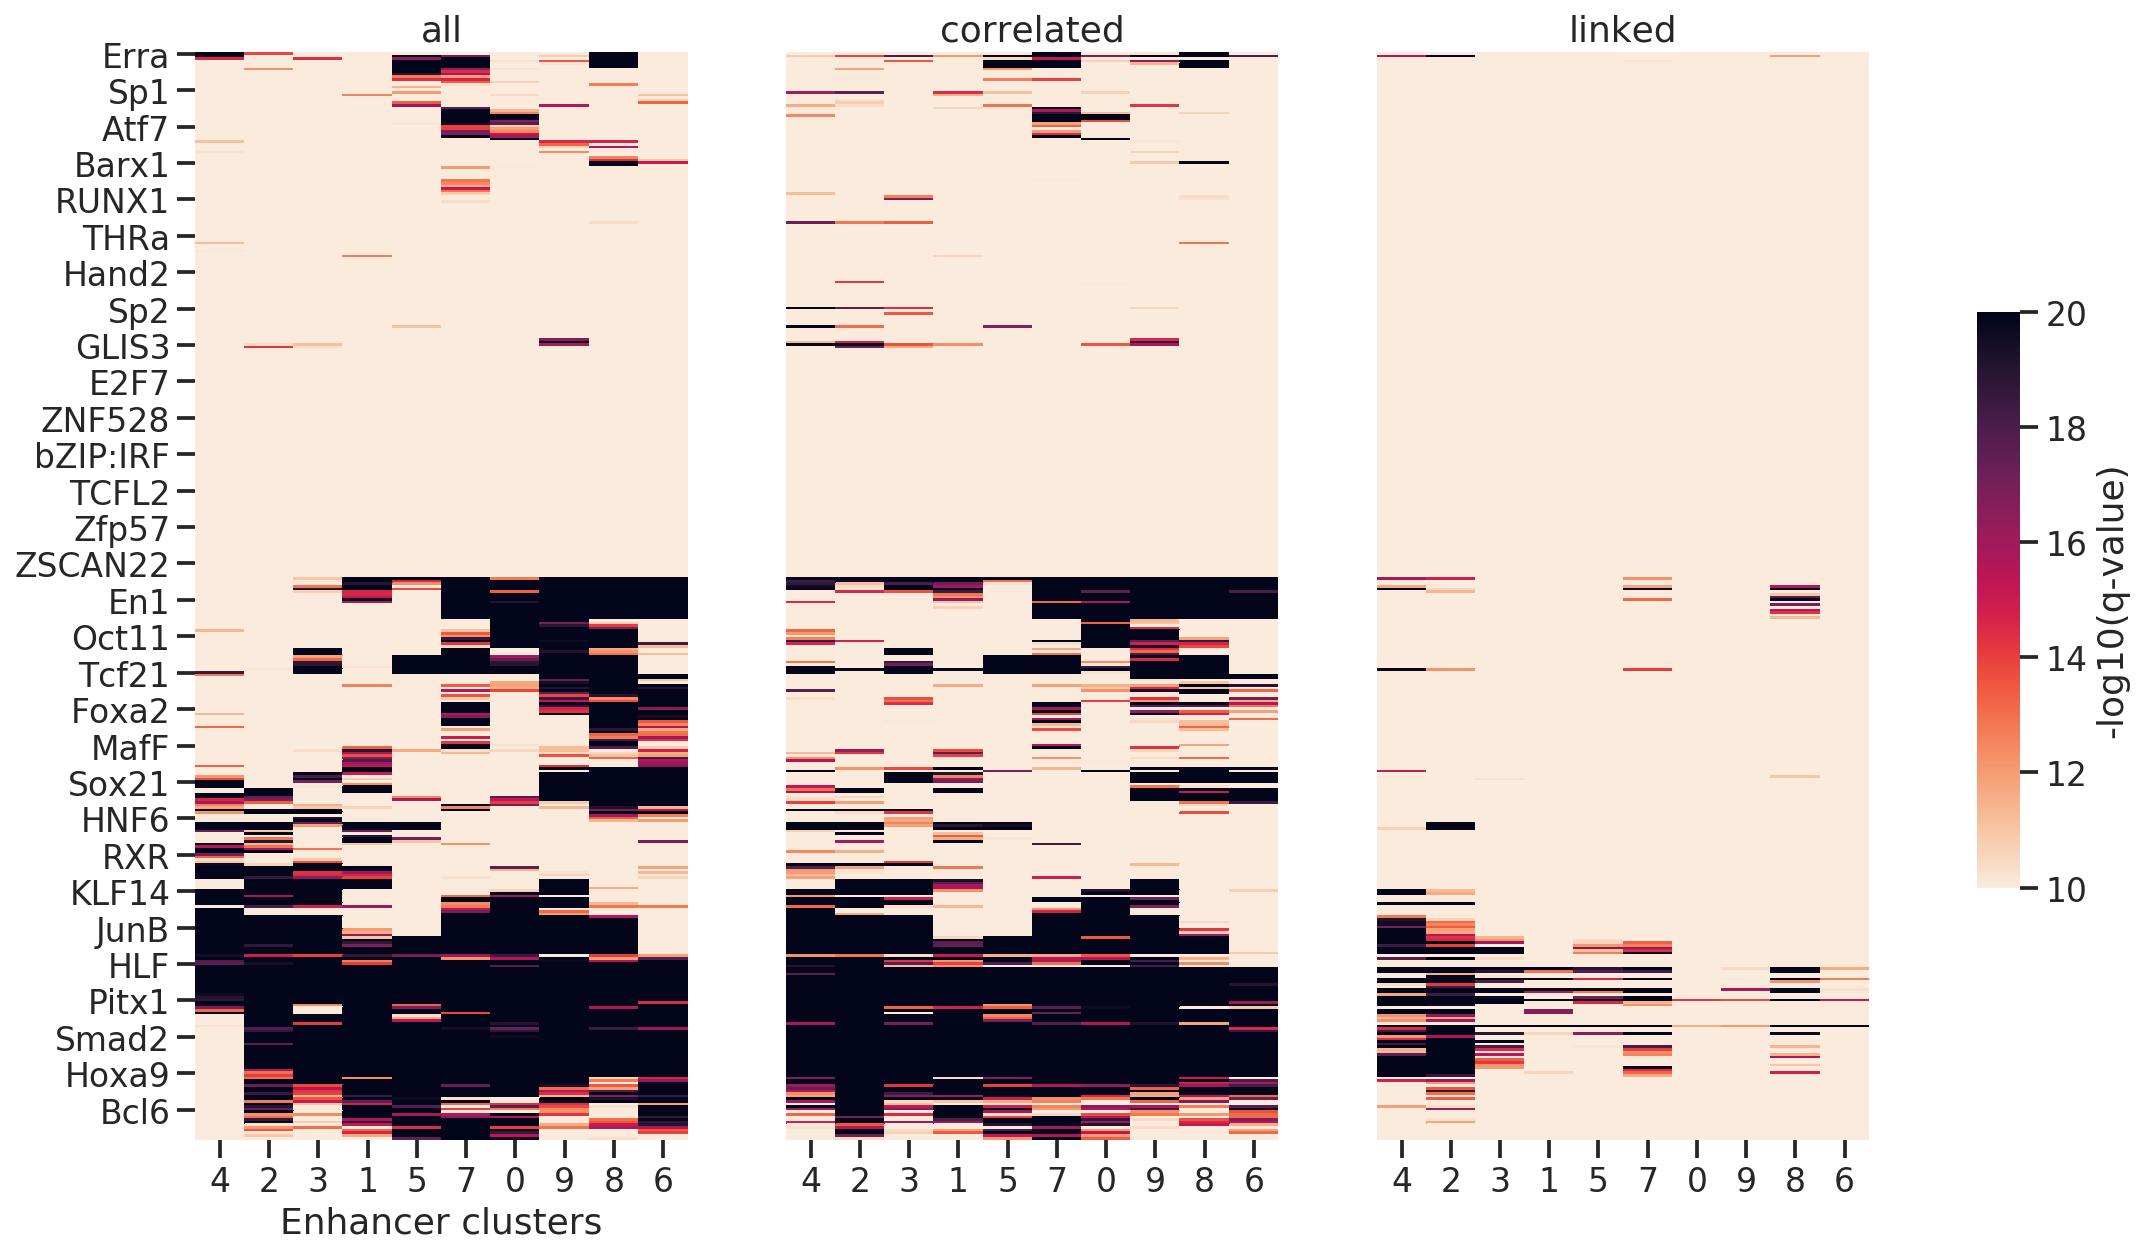

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
#         ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        ylabel = ''
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=10, vmax=20, 
                cbar=cbar, cbar_kws={'label': '-log10(q-value)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    
snmcseq_utils.savefig(fig, output_figures.format('heatmaps_qvals_motif'))
plt.show()

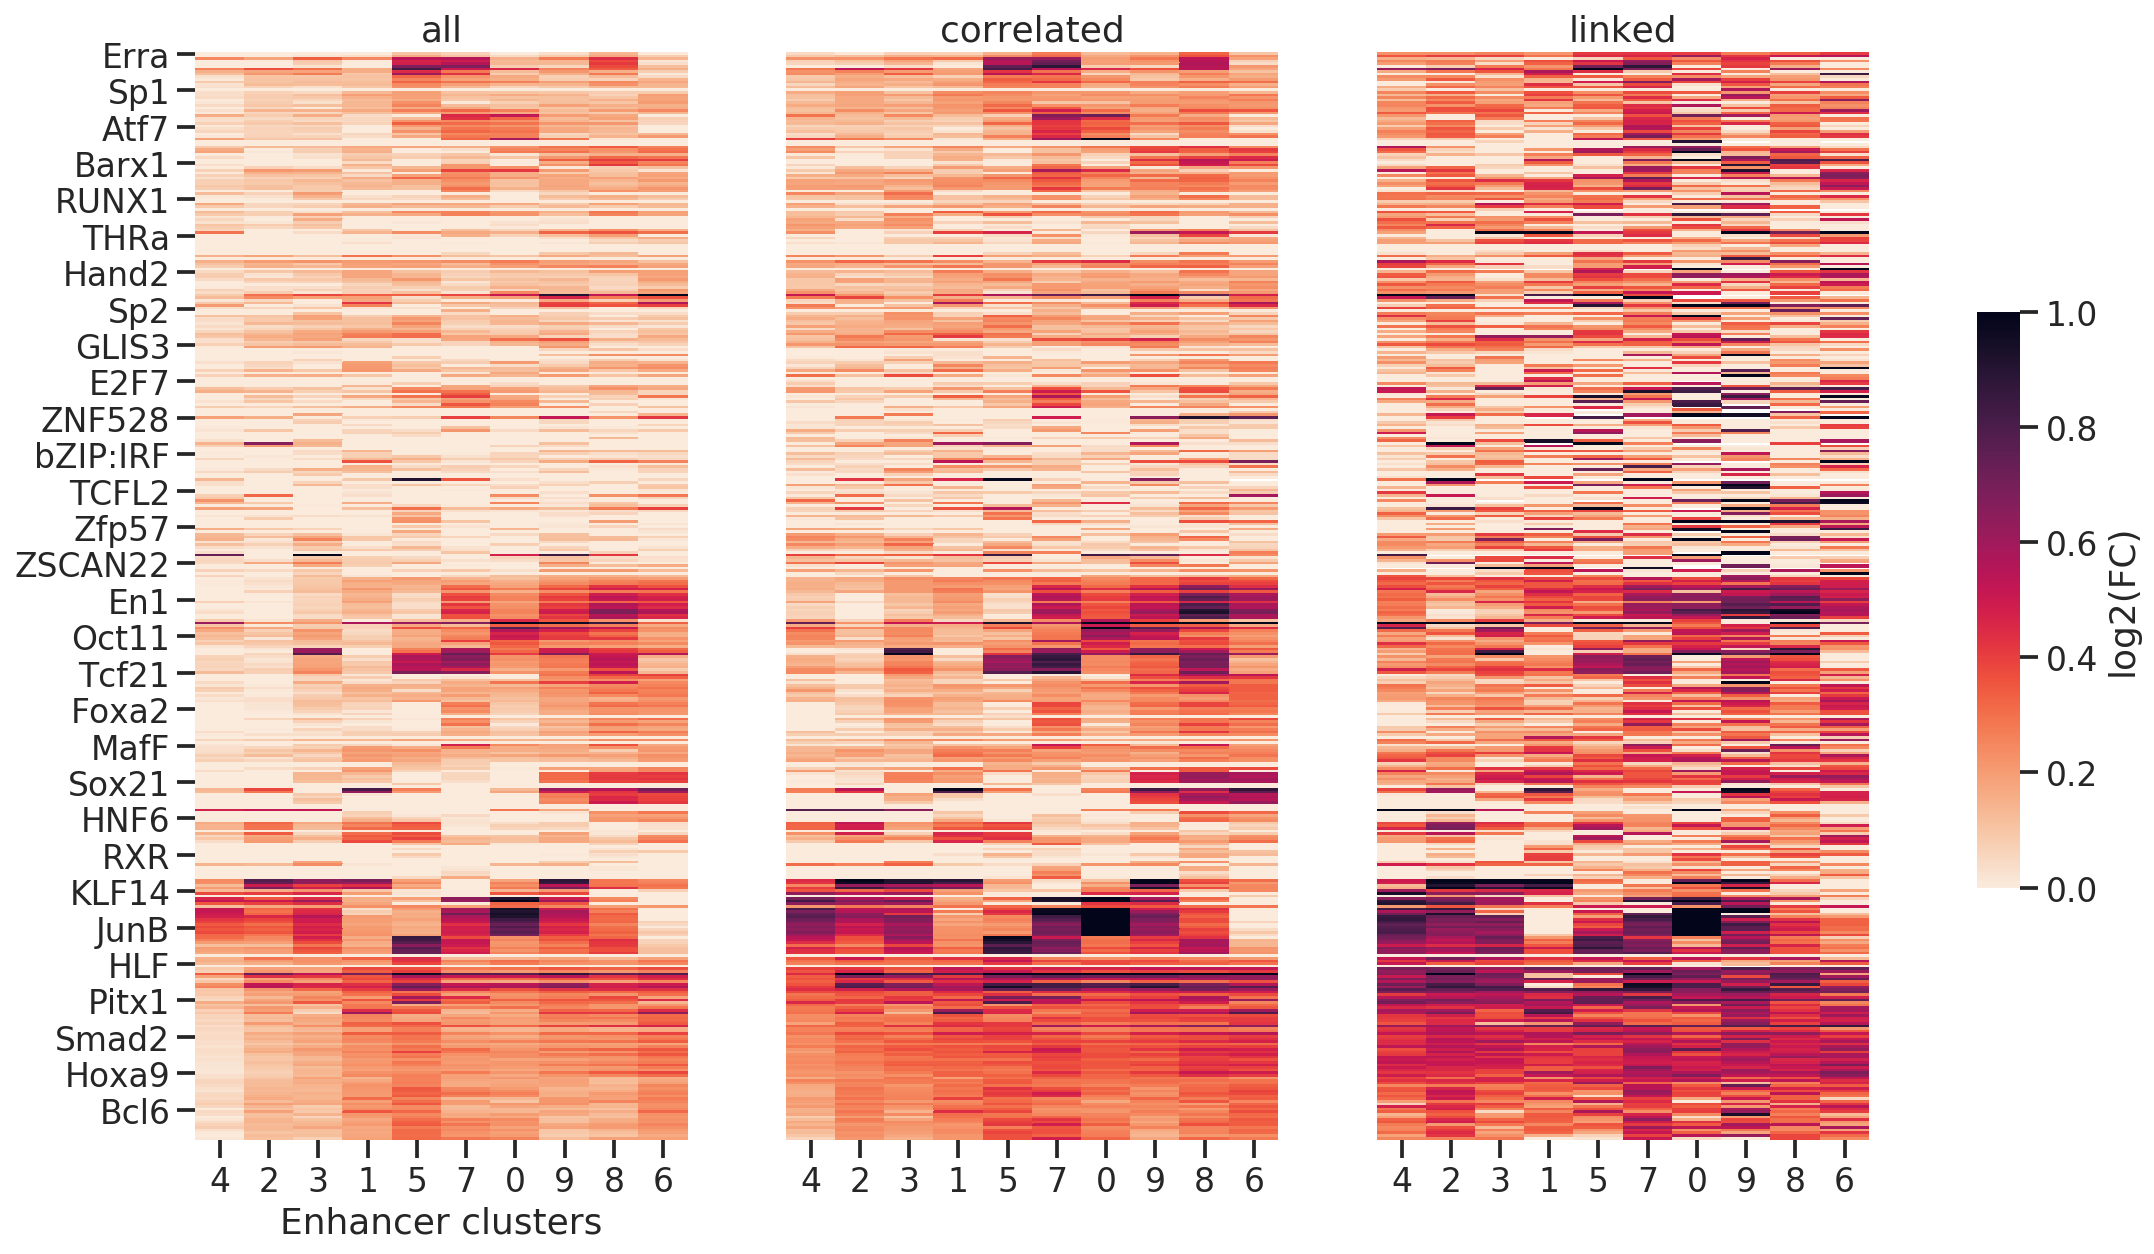

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
#         ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        ylabel = ''
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=0, 
                vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

snmcseq_utils.savefig(fig, output_figures.format('heatmaps_fc_motif'))
plt.show()

In [19]:
# import itertools

# boxplot_df = pd.DataFrame(columns=mat_labels)
# for i, (mat, label) in enumerate(zip(mats2, mat_labels)):
#     boxplot_df[label] = np.hstack(mat.values)
    
# for a, b in itertools.combinations(mat_labels, 2):
#     t, p = stats.ttest_rel(boxplot_df[a], boxplot_df[b])
#     print(a, b, t, p)

# fig, ax = plt.subplots(figsize=(3,4))
# sns.violinplot(data=boxplot_df, ax=ax)
# ax.set_xlabel('Enhancer types')
# ax.set_ylabel('log2(FC)')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_title('Overall motif enrichment (each point is the log2(FC) of'
#              '\n a motif in an enhancer cluster compared with random regions)')

# ax.hlines([1.2], xmin=0, xmax=1)
# ax.text(0.5, 1.2, '***', ha='center')
# ax.hlines([1.4], xmin=1, xmax=2)
# ax.text(1.5, 1.4, '***', ha='center')
# ax.hlines([1.6], xmin=0, xmax=2)
# ax.text(1, 1.6, '***', ha='center')
# sns.despine(ax=ax)

# snmcseq_utils.savefig(fig, output_figures.format('violin_plot_motif_enrichment'))
# plt.show()

In [20]:
to_plot_shuff.head()

,clst0_all,clst0_correlated,clst0_linked,clst1_all,clst1_correlated,clst1_linked,clst2_all,clst2_correlated,clst2_linked,clst3_all,...,clst6_linked,clst7_all,clst7_correlated,clst7_linked,clst8_all,clst8_correlated,clst8_linked,clst9_all,clst9_correlated,clst9_linked
Motif Name,,,,,,,,,,,,,,,,,,,,,
AMYB,7.427834,5.404762,1.451576,9.862433,7.137432,1.152208,2.731679,8.869738,6.143314,3.808828,...,0.746651,9.908065,6.730807,4.518668,9.028002,7.331233,2.344658,8.621326,9.141511,0.048310
AP-1,0.325644,2.170867,0.259978,0.917253,2.008926,0.259217,0.002641,0.973848,2.514405,1.921346,...,0.445099,1.896025,0.837162,0.022609,1.429624,1.800958,0.088613,3.030543,2.047248,0.069161
AP-2alpha,0.343127,0.057370,0.114320,0.345340,0.251003,0.097983,0.345954,0.204428,0.826034,0.382278,...,0.280627,0.178799,0.000271,0.015190,0.164350,0.205047,0.010099,0.540790,0.242413,0.100613
AP-2gamma,0.532120,0.227904,0.131216,1.407898,0.279939,0.231066,0.136061,0.296578,0.661276,0.409070,...,0.297724,0.053691,0.400974,0.291632,0.401470,0.185947,0.141261,0.909767,0.432107,0.204424
AR-halfsite,20.000000,20.000000,11.024518,20.000000,20.000000,14.513781,20.000000,20.000000,20.000000,20.000000,...,7.287246,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,7.163821


In [21]:
mat_labels = [
    'all shuff', 'correlated shuff', 'linked shuff',
    'all', 'correlated', 'linked',
]
palette = {label: 'white' if label.endswith('shuff') else 'gray' for label in mat_labels}

mats = [
    to_plot_shuff.filter(regex=r'_all$', axis=1),    
    to_plot_shuff.filter(regex=r'_correlated$', axis=1),    
    to_plot_shuff.filter(regex=r'_linked$', axis=1),    
    
    to_plot.filter(regex=r'_all$', axis=1),    
    to_plot.filter(regex=r'_correlated$', axis=1),    
    to_plot.filter(regex=r'_linked$', axis=1),    
]

mats2 = [
    to_plot_shuff2.filter(regex=r'_all$', axis=1),    
    to_plot_shuff2.filter(regex=r'_correlated$', axis=1),    
    to_plot_shuff2.filter(regex=r'_linked$', axis=1),    
    
    to_plot2.filter(regex=r'_all$', axis=1),    
    to_plot2.filter(regex=r'_correlated$', axis=1),    
    to_plot2.filter(regex=r'_linked$', axis=1),    
]


mat_labels = mat_labels[::3] + mat_labels[1::3] + mat_labels[2::3]
mats = mats[::3] + mats[1::3] + mats[2::3]
mats2 = mats2[::3] + mats2[1::3] + mats2[2::3]

(418, 10)
(418, 10)
(418, 10)
(418, 10)
(418, 10)
(418, 10)
all shuff all nan nan
all shuff correlated shuff nan nan
all shuff correlated nan nan
all shuff linked shuff nan nan
all shuff linked nan nan
all correlated shuff nan nan
all correlated nan nan
all linked shuff nan nan
all linked nan nan
correlated shuff correlated nan nan
correlated shuff linked shuff nan nan
correlated shuff linked nan nan
correlated linked shuff nan nan
correlated linked nan nan
linked shuff linked nan nan


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/scipy/stats/stats.py:5770: RuntimeWarning: invalid value encountered in subtract
  d = (a - b).astype(np.float64)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


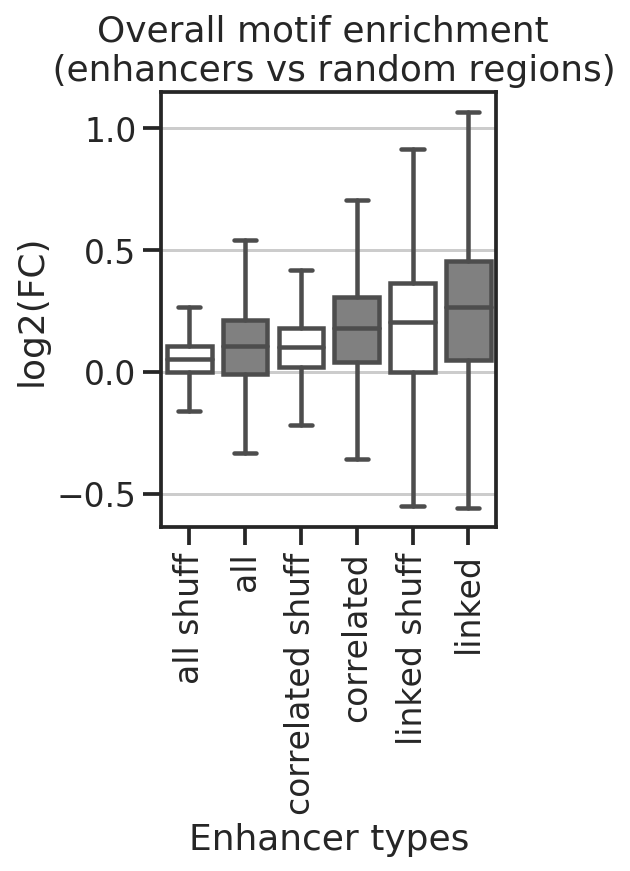

In [24]:
boxplot_df = pd.DataFrame(columns=mat_labels)
for i, (mat, label) in enumerate(zip(mats2, mat_labels)):
    print(mat.shape)
    boxplot_df[label] = np.hstack(mat.values)
# for a, b in itertools.combinations(mat_labels, 2):
#     t, p = stats.ttest_rel(boxplot_df[a], boxplot_df[b])
#     print(a, b, t, p)
for a, b in itertools.combinations(mat_labels, 2):
    t, p = stats.ttest_rel(boxplot_df[a], boxplot_df[b])
    print(a, b, t, p)

fig, ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=boxplot_df, palette=palette, ax=ax, showfliers=False)
# sns.violinplot(data=boxplot_df, palette=palette, ax=ax)
ax.set_xlabel('Enhancer types')
ax.set_ylabel('log2(FC)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Overall motif enrichment \n (enhancers vs random regions)')

# ax.hlines([1.2], xmin=0, xmax=1)
# ax.text(0.5, 1.2, '***', ha='center')
# ax.hlines([1.4], xmin=1, xmax=2)
# ax.text(1.5, 1.4, '***', ha='center')
# ax.hlines([1.6], xmin=0, xmax=2)
# ax.text(1, 1.6, '***', ha='center')
# sns.despine(ax=ax)

snmcseq_utils.savefig(fig, output_figures.format('violin_plot_motif_enrichment_v2'))
plt.show()

In [25]:
mat_labels = [
    'all shuff', 'correlated shuff', 'linked shuff',
    'all', 'correlated', 'linked',
]
palette = {label: 'white' if label.endswith('shuff') else 'gray' for label in mat_labels}

mats = [
    to_plot_shuff.filter(regex=r'_all$', axis=1),    
    to_plot_shuff.filter(regex=r'_correlated$', axis=1),    
    to_plot_shuff.filter(regex=r'_linked$', axis=1),    
    
    to_plot.filter(regex=r'_all$', axis=1),    
    to_plot.filter(regex=r'_correlated$', axis=1),    
    to_plot.filter(regex=r'_linked$', axis=1),    
]

mats2 = [
    to_plot_shuff2.filter(regex=r'_all$', axis=1),    
    to_plot_shuff2.filter(regex=r'_correlated$', axis=1),    
    to_plot_shuff2.filter(regex=r'_linked$', axis=1),    
    
    to_plot2.filter(regex=r'_all$', axis=1),    
    to_plot2.filter(regex=r'_correlated$', axis=1),    
    to_plot2.filter(regex=r'_linked$', axis=1),    
]


# mat_labels = mat_labels[::3] + mat_labels[1::3] + mat_labels[2::3]
# mats = mats[::3] + mats[1::3] + mats[2::3]
# mats2 = mats2[::3] + mats2[1::3] + mats2[2::3]

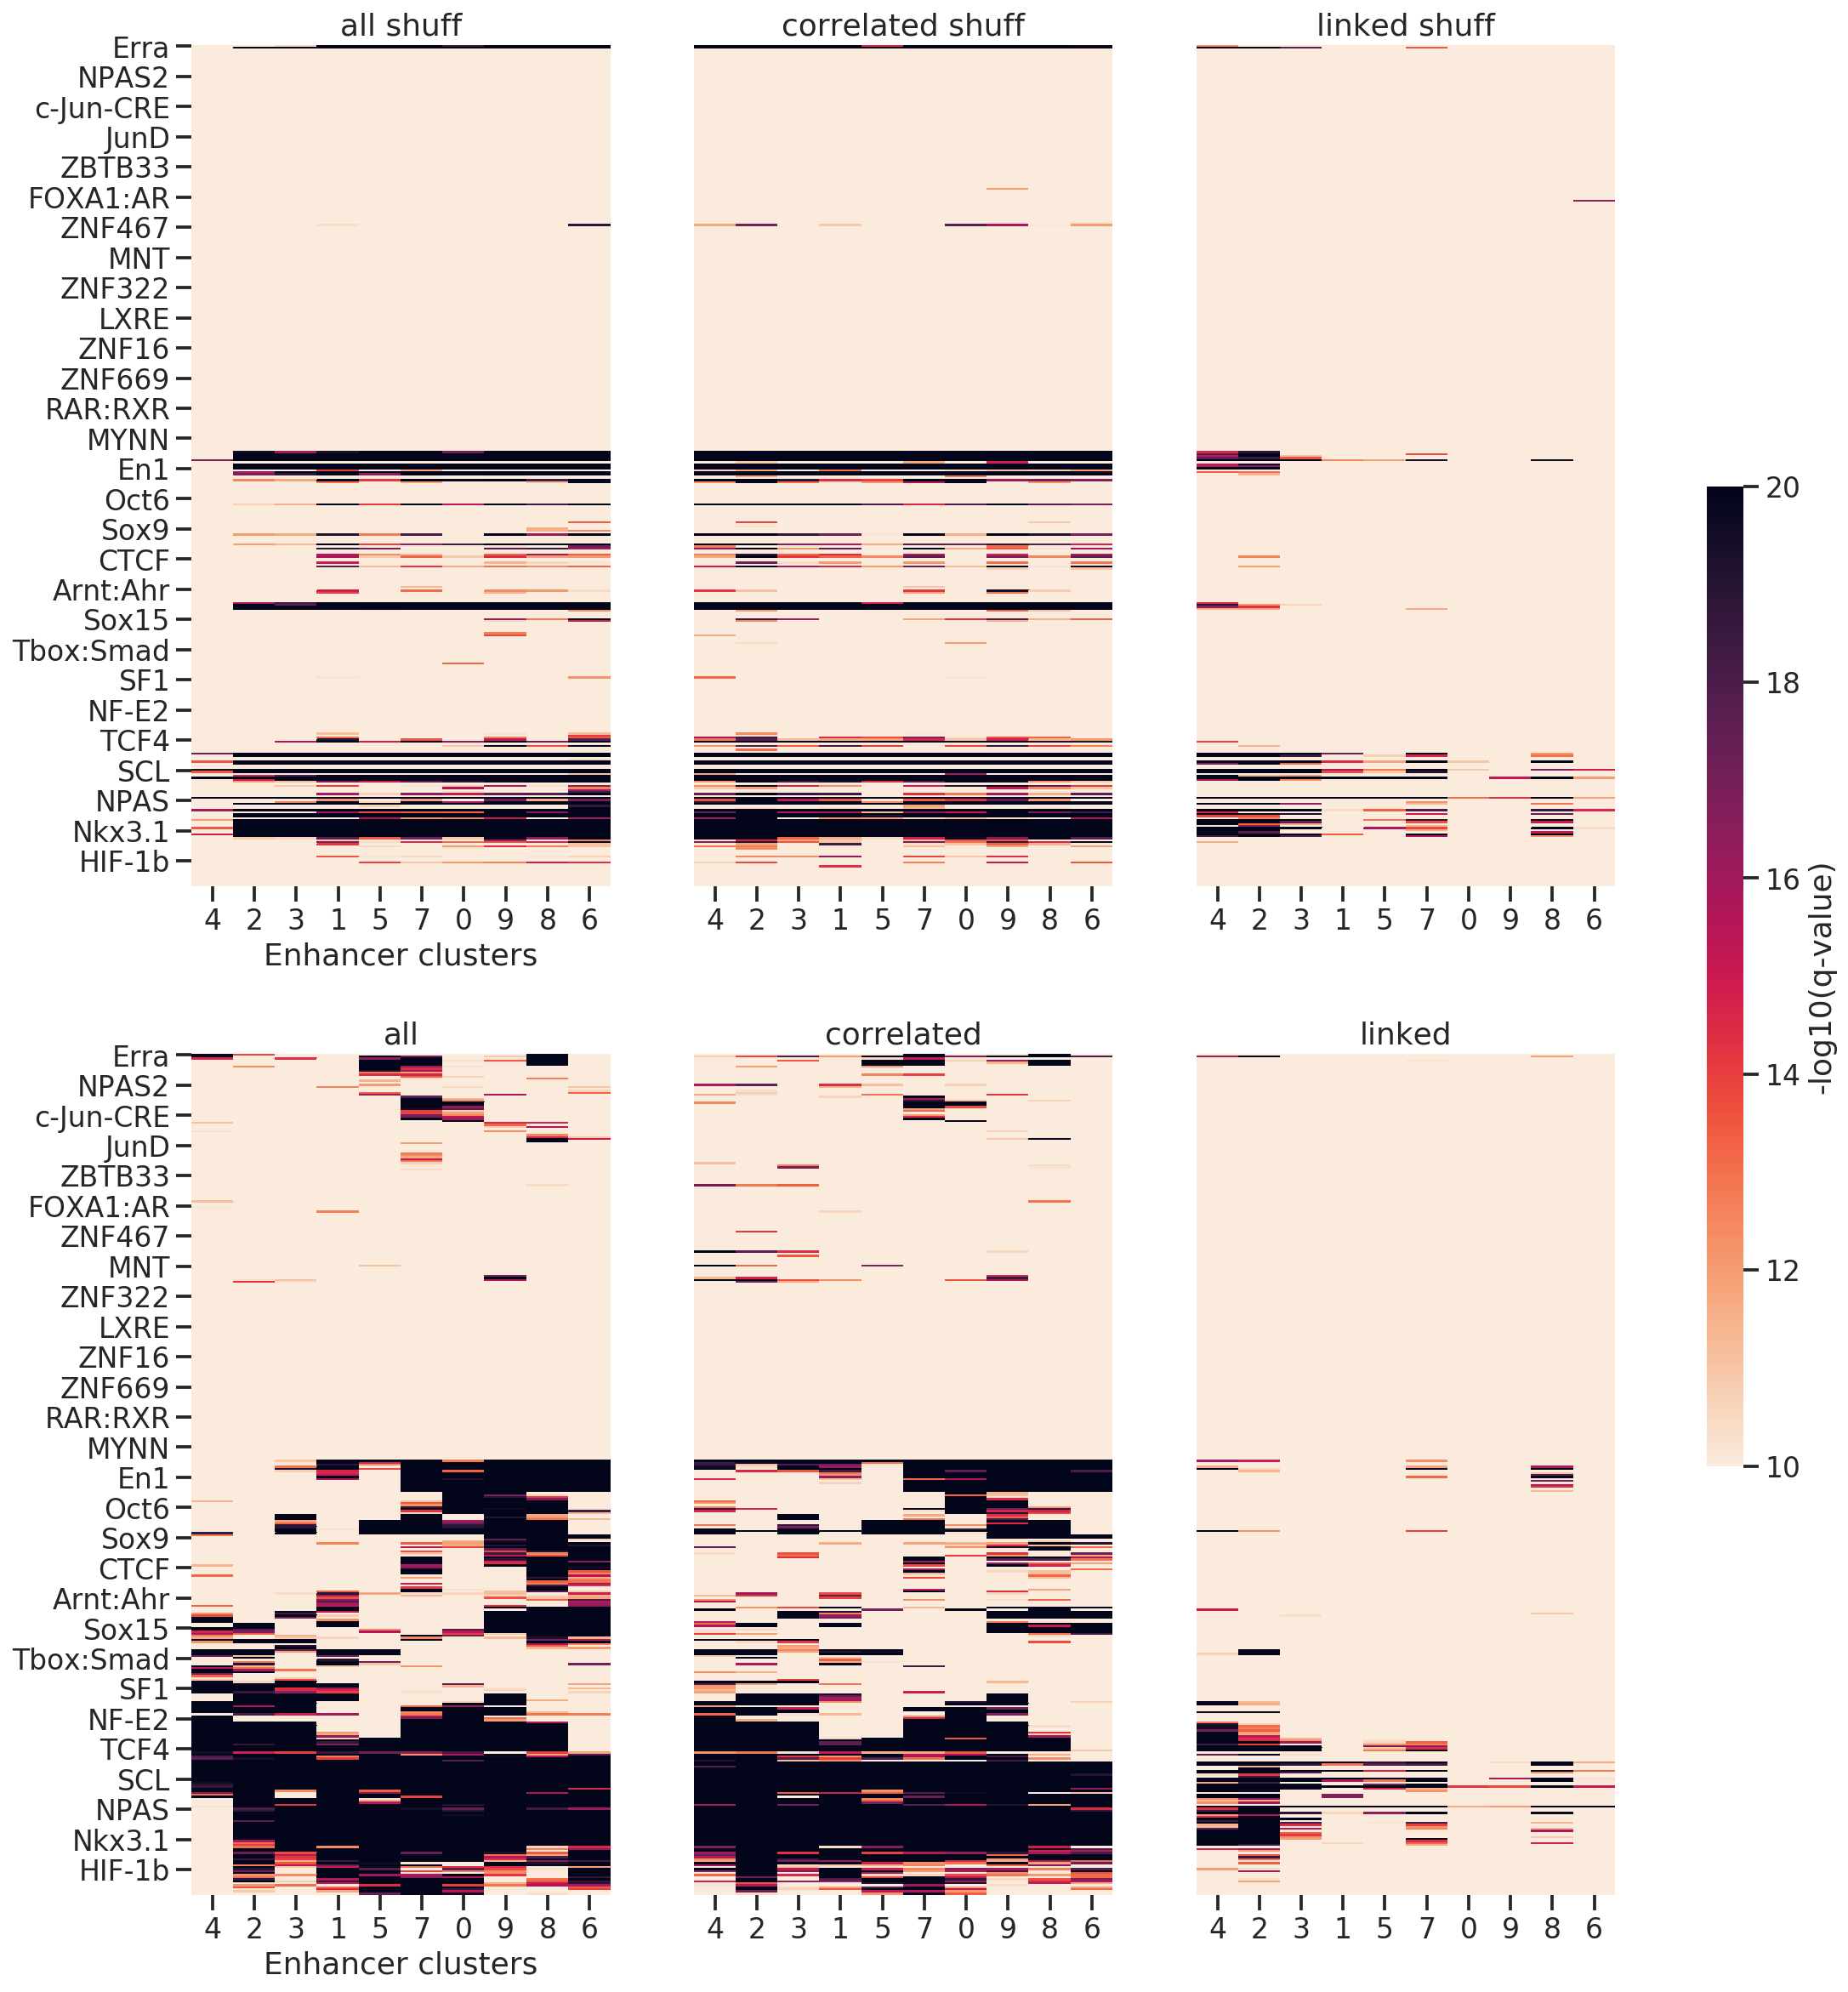

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(3*5, 2*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs.flat, mats, mat_labels)): 
    if i in [0, 3]:
        yticklabels = 'auto'
#         ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        ylabel = ''
        xlabel = "Enhancer clusters" 
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
    if i == 0:
        cbar = True
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=10, vmax=20, 
                cbar=cbar, cbar_kws={'label': '-log10(q-value)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    
snmcseq_utils.savefig(fig, output_figures.format('heatmaps_qvals_motif'))
plt.show()

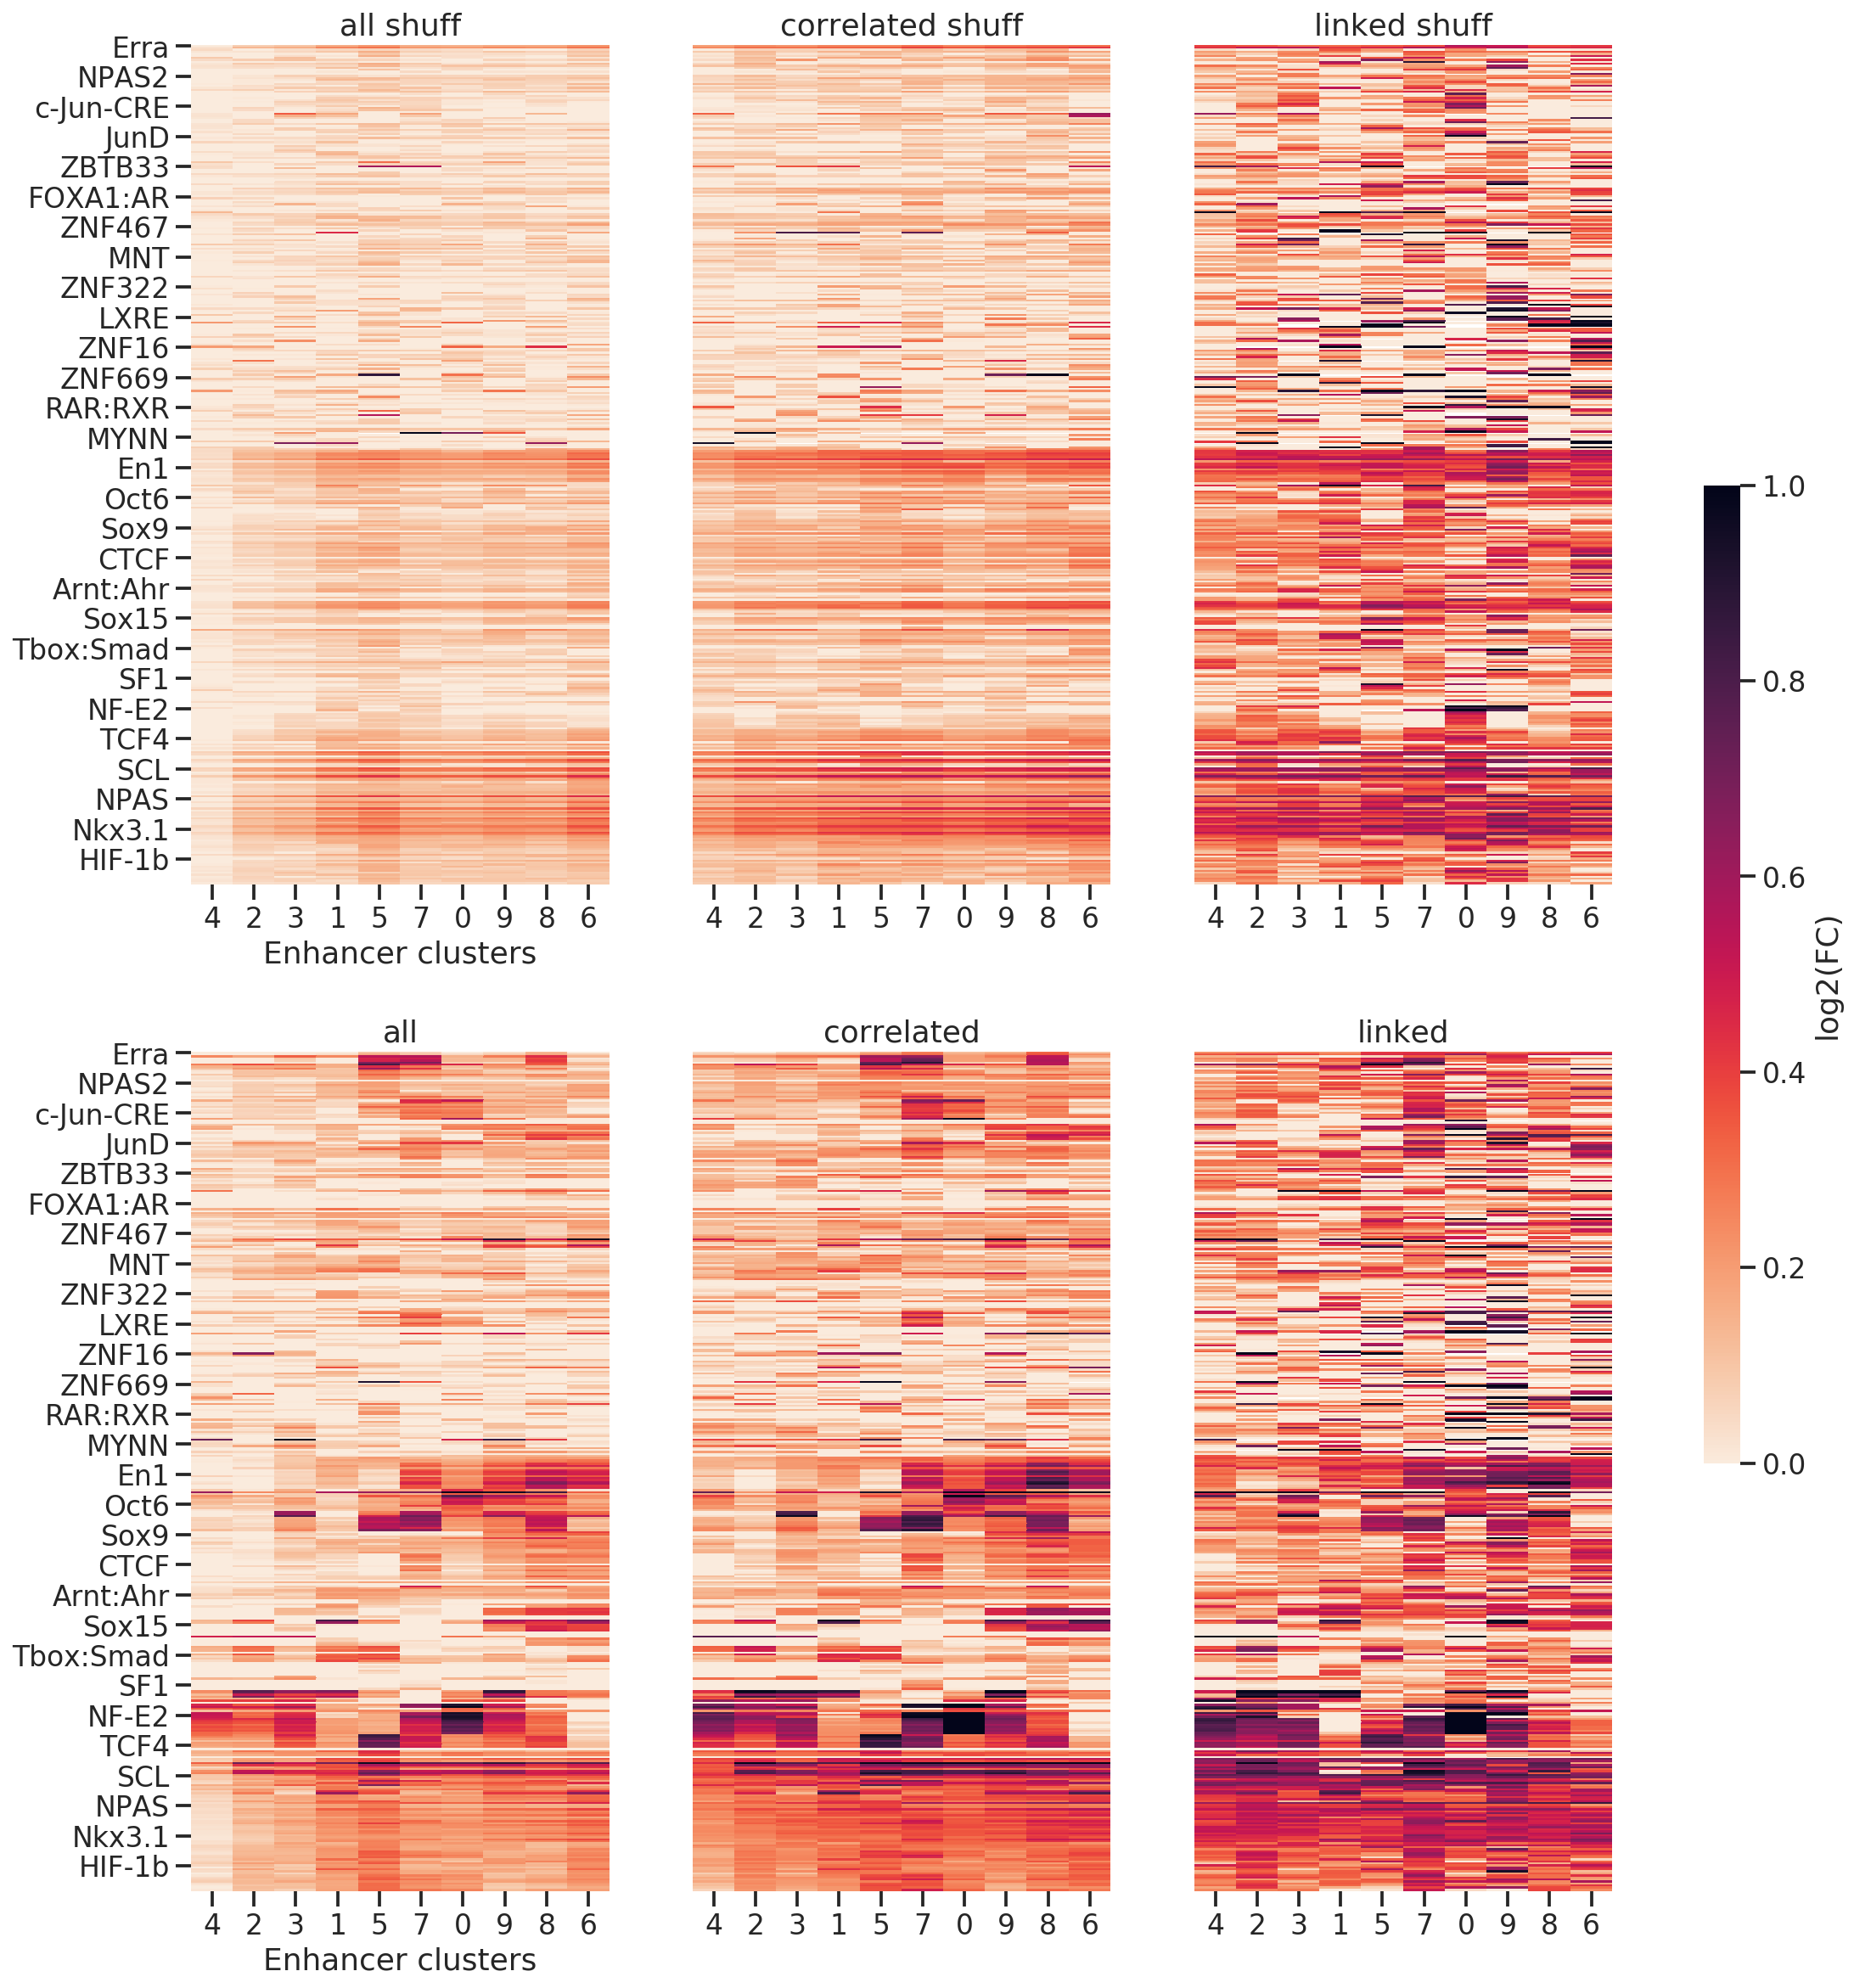

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(3*5, 2*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs.flat, mats2, mat_labels)): 
    if i in [0, 3]:
        yticklabels = 'auto'
#         ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        ylabel = ''
        xlabel = "Enhancer clusters" 
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
    if i == 0:
        cbar = True
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=0, 
                vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

snmcseq_utils.savefig(fig, output_figures.format('heatmaps_fc_motif'))
plt.show()

### Top enriched for each cluster

In [ ]:
mats[0].reindex((mats[0]>10).sum(axis=1).sort_values(ascending=False).index).head(10).index

In [ ]:
# most differential across enhancer clusters
ntop = 30
# top_variable = mats2[0].std(axis=1).nlargest(ntop).index
# top_variable = ['Dlx1', 'Dlx2']
top_variable = mats[0].reindex((mats[0]>10).sum(axis=1).sort_values(ascending=False).index).head(10).index
# mats[0]

fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
#         ylabel = "top {} most variable TF binding Motifs\n(from {} motifs with qvalue<1e-{} in >=1 cluster)".format(ntop, len(mat), fdr_th) 
        ylabel = ''
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[:,clst_orders].reindex(top_variable),  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=0, vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
                linewidth=1,
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

In [ ]:
fig, axs = plt.subplots(ntop, 1, figsize=(5, 0.5*ntop))
for ax, motif in zip(axs, top_variable.values):
    logomaker.Logo(motif_pwms[motif], 
                   show_spines=False,
                   fade_probabilities=True,
                   ax=ax,
                   )
    ax.set_ylabel(motif, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [ ]:
ntop = 30

# most differential between the top enriched and the second top
# new order
sorted_mat = np.sort(mats2[0].values, axis=1)
specific_motif_order = np.argsort(sorted_mat[:,-1]-sorted_mat[:,-2])[::-1][:ntop]

fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "top {} most specific TF binding Motifs\n(from {} motifs with qvalue<1e-{} in >=1 cluster)".format(ntop, len(mat), fdr_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[specific_motif_order, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', vmin=0, vmax=1, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
                linewidth=1,
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

In [ ]:
fig, axs = plt.subplots(ntop, 1, figsize=(5, 0.5*ntop))
for ax, motif in zip(axs, pmat.iloc[specific_motif_order].index.values):
    logomaker.Logo(motif_pwms[motif], 
                   show_spines=False,
                   fade_probabilities=True,
                   ax=ax,
                   )
    ax.set_ylabel(motif, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

# Compare enrichment and depletion within a category 

In [ ]:
# now fg ~ linked fg; bg ~ fg all
k = mat_fg.filter(regex=r"_linked$")
M = mat_fg.filter(regex=r'_all$')+mat_nfg.filter(regex=r"_all$")
N = mat_fg.filter(regex=r"_linked$")+mat_nfg.filter(regex=r"_linked$")
n = mat_fg.filter(regex=r"_all$")
for mat in [k, M, N, n]:
    mat.columns = [col.split('_')[0] for col in mat.columns]
_, adjpvals_v1 = hypogeom_test_pipe(k, M, n, N)
log2fc_v1 = np.log2((k/N)/(n/M))
# log2fc_v1 = pd.DataFrame(
#     np.log2((k.values/N.values)/(n.values/M.values)),
#     index=k.index,
#     columns=k.columns,
# )

# now fg ~ linked fg; bg ~ fg correlated
k = mat_fg.filter(regex=r"_linked$")
M = mat_fg.filter(regex=r'_correlated$')+mat_nfg.filter(regex=r"_correlated$")
N = mat_fg.filter(regex=r"_linked$")+mat_nfg.filter(regex=r"_linked$")
n = mat_fg.filter(regex=r"_correlated$")
for mat in [k, M, N, n]:
    mat.columns = [col.split('_')[0] for col in mat.columns]
_, adjpvals_v2 = hypogeom_test_pipe(k, M, n, N)
log2fc_v2 = np.log2((k/N)/(n/M))

# now fg ~ correlated fg; bg ~ fg all
k = mat_fg.filter(regex=r"_correlated$")
M = mat_fg.filter(regex=r'_all$')+mat_nfg.filter(regex=r"_all$")
N = mat_fg.filter(regex=r"_correlated$")+mat_nfg.filter(regex=r"_correlated$")
n = mat_fg.filter(regex=r"_all$")
for mat in [k, M, N, n]:
    mat.columns = [col.split('_')[0] for col in mat.columns]
_, adjpvals_v3 = hypogeom_test_pipe(k, M, n, N)
log2fc_v3 = np.log2((k/N)/(n/M))


In [ ]:
# # qvalues clip at 1e-20
# for adjpvals_v in [
#         adjpvals_v1, 
#         adjpvals_v2, 
#         adjpvals_v3, 
#     ]:
#     _x = np.clip(-np.log10(adjpvals_v2).values, 0, 20)
#     print(np.max(_x[np.isfinite(_x)]))
    
#     fig, ax = plt.subplots()
#     ax.hist(np.hstack(_x), bins=20)
#     plt.show()
# k/N
# (k/N)/(n/M)

# visualization

In [ ]:
to_plots = [
    np.clip(-np.log10(adjpvals_v1), 0, 20),
    np.clip(-np.log10(adjpvals_v2), 0, 20),
    np.clip(-np.log10(adjpvals_v3), 0, 20),
]

to_plots2 = [
    np.clip(log2fc_v1.fillna(0), 0, 2),
    np.clip(log2fc_v2.fillna(0), 0, 2),
    np.clip(log2fc_v3.fillna(0), 0, 2),
]
# filter motifs
fdr_th = 2 # 10^-2
log2fc_th = np.log2(1.5) 
conds = [
    ((to_plot>fdr_th) & (to_plot2>log2fc_th)).sum(axis=1) > 0
    for to_plot, to_plot2 in zip(to_plots, to_plots2)
]
cond = ((conds[0]) | (conds[1]) | (conds[2]))
print(len(cond), cond.sum())

mat_labels = [
    'linked vs all', 
    'linked vs correlated',
    'correlated vs all', 
]

mats = [to_plot[cond].copy() for to_plot in to_plots]
mats2 = [to_plot[cond].copy() for to_plot in to_plots2]

# merge motifs (adhoc)
if MERGE_SIMILAR_MOTIFS_ADHOC:
    for i in np.arange(len(mats)):
        mats[i]['motif_clst'] = [similar_motif_dict[motif] 
                                 for motif in mats[i].index]
        mats[i] = mats[i].groupby('motif_clst').max()
    for i in np.arange(len(mats2)):
        mats2[i]['motif_clst'] = [similar_motif_dict[motif] 
                                 for motif in mats2[i].index]
        mats2[i] = mats2[i].groupby('motif_clst').max()

In [ ]:
# hierarchical clustering (motif and cluster order)
pmat = mats[0]

Z = sch.linkage(pmat, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
motif_orders = np.array(g['ivl']).astype(int)

Z = sch.linkage(pmat.T, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
clst_orders = np.array(g['ivl']).astype(int)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=2, vmax=10, 
                cbar=cbar, cbar_kws={'label': '-log10(q-value)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3*5, 1*10))
l, b, w, h = 0.95, 0.3, 0.02, 0.4
cbar_ax = fig.add_axes([l, b, w, h])

for i, (ax, mat, label) in enumerate(zip(axs, mats2, mat_labels)): 
    if i == 0:
        yticklabels = 'auto'
        ylabel = "{} TF binding Motifs\n(All motifs with qvalue<1e-{} and fc>2^{:.1f} in >=1 cluster)".format(len(mat), fdr_th, log2fc_th) 
        xlabel = "Enhancer clusters" 
        cbar = True
    else: 
        yticklabels = False
        ylabel = "" 
        xlabel = "" 
        cbar = False 
        
    mat.columns = [simplify_enhclst_name(col) for col in mat.columns]
    sns.heatmap(mat.iloc[motif_orders, clst_orders],  
                ax=ax, 
                yticklabels=yticklabels,
                cmap='rocket_r', 
                vmin=0, vmax=2, 
                cbar=cbar, cbar_kws={'label': 'log2(FC)', 'shrink': 0.5},
                cbar_ax=(None if i else cbar_ax), # only draw if i==0
               )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(label)

plt.show()

In [ ]:
sns.distplot(np.clip(np.hstack(log2fc_v1.values), 0, 3))